# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

**Answer**: This seems like a classification task, as we are are predicting a binary output (pass or fail) as opposed to a continuous output, for which regression would be more suited.

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

In [43]:
# Import libraries
import numpy as np
import pandas as pd
import graphviz

In [10]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print("Student data read successfully!")
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [11]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data)
n_features = len(student_data.columns) - 1  # exclude 'passed' column
n_passed = np.sum(student_data['passed'] == 'yes')
n_failed = np.sum(student_data['passed'] == 'no')
grad_rate = n_passed / (n_passed + n_failed) * 100  # python 3 uses "true division"
print("Total number of students: {}".format(n_students))
print("Number of students who passed: {}".format(n_passed))
print("Number of students who failed: {}".format(n_failed))
print("Number of features: {}".format(n_features))
print("Graduation rate of the class: {:.2f}%".format(grad_rate))

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [12]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print("Feature column(s):-\n{}".format(feature_cols))
print("Target column: {}".format(target_col))

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed


### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [13]:
# Preprocess feature columns
# Note: this preprocesses all columns include the "target" column which needs
# to be converted from ["yes", "no"] to [1, 0]
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

student_data = preprocess_features(student_data)
print("Processed feature columns ({}):-\n{}".format(len(student_data.columns), list(student_data.columns)))

Processed feature columns (49):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'passed']


In [14]:
y_all = student_data[target_col]  # corresponding targets/labels
X_all = student_data.drop([target_col], axis=1)  # feature values for all students
print("\nFeature values:-")
print(X_all.head())  # print the first 5 rows


Feature values:-
   school_GP  school_MS  sex_F  sex_M  age  address_R  address_U  famsize_GT3  \
0          1          0      1      0   18          0          1            1   
1          1          0      1      0   17          0          1            1   
2          1          0      1      0   15          0          1            0   
3          1          0      1      0   15          0          1            1   
4          1          0      1      0   16          0          1            1   

   famsize_LE3  Pstatus_A    ...     higher  internet  romantic  famrel  \
0            0          1    ...          1         0         0       4   
1            0          0    ...          1         1         0       5   
2            1          0    ...          1         1         0       4   
3            0          0    ...          1         1         1       3   
4            0          0    ...          1         0         0       4   

   freetime  goout  Dalc  Walc  health  abse

### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [15]:
from sklearn.cross_validation import train_test_split
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=(num_train / num_all), random_state=99)

print("Training set: {} samples".format(X_train.shape[0]))
print("Test set: {} samples".format(X_test.shape[0]))
# Note: If you need a validation set, extract bit from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [16]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    return (end - start)

# TODO: Choose a model, import it and instantiate an object
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=4)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here

0.005196094512939453

In [44]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target, metric_func=f1_score):
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    return metric_func(target.values, y_pred), (end - start)

train_f1_score = predict_labels(clf, X_train, y_train)
print("F1 score for training set: {}".format(train_f1_score[0]))

F1 score for training set: 0.8108108108108109


In [18]:
# Predict on test data
print("F1 score for test set: {}".format(predict_labels(clf, X_test, y_test)[0]))

F1 score for test set: 0.8029197080291971


In [19]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    train_time = train_classifier(clf, X_train, y_train)
    f1_train, prediction_time_train = predict_labels(clf, X_train, y_train)
    f1_test, prediction_time_test, = predict_labels(clf, X_test, y_test)
    return f1_train, f1_test, train_time, np.mean([prediction_time_train, prediction_time_test])

In [20]:
def train_and_evaluate_classifier(clf, training_sizes=(100, 200, len(X_train))):
    """Evaluate and train a classifier. reports f1 score on train and test data,
    as well as training and prediction time for various training sizes.
    Uses the student data defined in the global namespace.
    """
    scores = []
    for k in training_sizes:
        # data has already been shuffled, so we just use first k samples
        f1_train, f1_test, train_time, prediction_time = train_predict(clf, X_train[:k], y_train[:k], X_test, y_test)
        scores.append([k, f1_train, f1_test, train_time, prediction_time])

    df = pd.DataFrame(scores, columns=['train_size', 'f1_train', 'f1_test', 'train_time', 'prediction_time'])
    return df

## Model 1: Decision Tree

In [26]:
from IPython.display import display
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

print("-" * 40)
print("Max Depth = None (all features used)")
display(train_and_evaluate_classifier(clf))

# Note, the base decision tree class overfits drastically, so we also show
# performance of a simple decision tree stump.
clf = DecisionTreeClassifier(max_depth=1)
print("-" * 40)
print("Max Depth = 1")
display(train_and_evaluate_classifier(clf))
print([x for x in X_all.columns[clf.feature_importances_ != 0.]])

----------------------------------------
Max Depth = None (all features used)


,train_size,f1_train,f1_test,train_time,prediction_time
0,100,1,0.776119,0.001009,0.000226
1,200,1,0.715447,0.001204,0.000200
2,300,1,0.621849,0.001928,0.000338


----------------------------------------
Max Depth = 1


,train_size,f1_train,f1_test,train_time,prediction_time
0,100,0.816568,0.774194,0.000693,0.000186
1,200,0.831746,0.802721,0.000426,0.000226
2,300,0.810811,0.812030,0.000714,0.000241


['failures']


- What is the theoretical O(n) time & space complexity in terms of input size?
> The sklearn implementation of a Decision Tree has a time complexity of [$O(D * n * log(n))$](http://scikit-learn.org/stable/modules/tree.html#complexity) where `D` is the number of features, and `n` is the number of samples. An $O(n * log(n))$ running time in the number of samples is relatively fast. Prediction times are very fast, taking `O(max_depth)`. Space complexity grows with the complexity of our tree, but will not exceed `D`. It can be limited with `max_depth`, as well as other parameters.

- What are the general applications of this model? What are its strengths and weaknesses?
> Decision trees are simple but robust classifiers. They can be easily visualized, and due to their simplicity they are very interpretable. Judging by our results above, they seems to perform reasonably well on small datasets. However, decision trees can also be prone to overfitting, which is why hyperparameter tuning is especially important. In this case we set `max_depth=2` to keep the implementation simple, and help us identify key features. Decision trees can also be very sensitive to outliers, where as little as one value can result in a completely different tree being generated.

- Given what you know about the data so far, why did you choose this model to apply?
> A Decision Tree Classifier was chosen for its simplicity and speed as a classifier. It is relatively easy to build and tune, and provides a quick way to identify the best splitting features and build a classifier. Identifying key splitting features in such a manner can simplify subsequent analysis. It seems as though 'failures' is the best feature to split on, and that we don't recieve benefit from splitting on other features thereafter.

## Model 2: K-Nearest Neighbors

In [30]:
from sklearn.neighbors import KNeighborsClassifier

print("-" * 40)
print("K = 5 (default)")
clf = KNeighborsClassifier()

display(train_and_evaluate_classifier(clf))

print("-" * 40)
print("K = 25")
clf = KNeighborsClassifier(n_neighbors=25)

display(train_and_evaluate_classifier(clf))

----------------------------------------
K = 5 (default)


,train_size,f1_train,f1_test,train_time,prediction_time
0,100,0.855172,0.696296,0.000746,0.001193
1,200,0.865248,0.740741,0.000542,0.002532
2,300,0.876404,0.733813,0.000783,0.003933


----------------------------------------
K = 25


,train_size,f1_train,f1_test,train_time,prediction_time
0,100,0.814371,0.786667,0.000622,0.001318
1,200,0.815047,0.781457,0.000511,0.002430
2,300,0.829569,0.791946,0.000601,0.005903


- What is the theoretical O(n) time & space complexity in terms of input size?
> KNN is very cheap to train, but query times can be more expensive. For a query, must identify the closest K neighbors, which involves sorting them by distance (which is also proportional to number of features, `D`). Therefore running time should be a worst case $O(D * n * log(n))$, assuming an algorithm like merge sort is used for sorting. Space complexity should never be more then `O(n)`, as all we need to do is keep track of our samples in memory.

- What are the general applications of this model? What are its strengths and weaknesses?
> KNN is another relatively simple algorithm that can easily be visualized and interpreted. However, performance can degrade at boundary conditions and when regions are not covered well with samples. Generally, we need a lot of data to cover our feature space; however, it appears that KNN performs well on the test set even when trained on only 100 samples. This could be because KNN is an instance-based algorithm: it is highly dependent on the training data – the first split represents our feature space almost as well as the whole dataset (when evaluated on our test set). We would expect this to vary with different splits. Furthermore, if we are doing a lot of predictions compared to training, it may not be well suited for our task. 

- Given what you know about the data so far, why did you choose this model to apply?
> The Decision Tree struggled and overfit quickly with `max_depth > 2`. We wanted to identify whether students would cluster in our feature space, as Decision Trees are not quite as good at identifying subtle correlations across many features: they split on the best feature at every iteration. KNN is a simple way to achieve this sort of clustering by performing a distance metric. It appears as though KNN achieves similar testing error on the data as the Decision Tree.


## Model 3: Support Vector Machine

In [31]:
from sklearn.svm import SVC

clf = SVC()
display(train_and_evaluate_classifier(clf))

,train_size,f1_train,f1_test,train_time,prediction_time
0,100,0.884615,0.777778,0.003896,0.001073
1,200,0.882353,0.778523,0.003995,0.002403
2,300,0.870488,0.797297,0.008295,0.004013


- What is the theoretical O(n) time & space complexity in terms of input size?
> Support Vector Machines have a worst case running time of [O(D * n^3)](http://scikit-learn.org/stable/modules/svm.html#complexity). This makes them much more expensive to train then either of our two previous models. This makes it hard to scale to applications with many samples. The space complexity is generally O(D * n) but can increase drastically based on caching optimizations used for algorithm performance.

- What are the general applications of this model? What are its strengths and weaknesses?
> Support Vector Machines use quadratic programming to find the optimal hyperplane to seperate two groups. SVMs often perform better then other classification methods because the optimal seperator on training is often superior to other seperators on testing data. Using the kernal trick, SVMs can also implicitely map features to higher dimensions, which can uncover patterns in data other algorithms can not. However, these complexities also result in less interpretable results then KNN or Decision Trees, and a much worse running complexity.

- Given what you know about the data so far, why did you choose this model to apply?
> KNN and Decision Trees seemed to perform similarly, I wanted to try SVMs to see if we could uncover some other patterns in the data. It seems like SVMs performed reasonabily well with no hyperparameter tuning.

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

In [36]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostClassifier

# Note: target variable is also transformed from ["yes", "no"] to [1, 0]
scorer = make_scorer(f1_score)

params = {
    'base_estimator': [DecisionTreeClassifier(max_depth=n) for n in [1, 2, 3, 4, 5, 10]],
    'n_estimators': [1, 5, 10, 20, 50, 100],
}

reg = AdaBoostClassifier()

clf = GridSearchCV(reg, param_grid=params, scoring=scorer)

display(train_and_evaluate_classifier(clf, [len(X_train)]))
print(clf.best_params_)

,train_size,f1_train,f1_test,train_time,prediction_time
0,300,0.810811,0.81203,6.313926,0.000327


{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), 'n_estimators': 1}


## Final Model

The final model we chose to deploy in production is **a simple decision tree**. We found that a one stump decision tree has a **slightly better `f1_score`** then KNN or SVM, while having **a lower time complexity**. By running Adaboost with GridSearch, we also saw that there was no added benefit of using multiple decision tree stumps, and that `max_depth=1` is the optimal depth parameter for the tree. Therefore, **Model #1** is our final model. 

Even though the `f1_test` score for `n_estimators=10` is better then that for `n_estimators=1`, the GridSearch determined that there is a lower training and cross-validation error with `n_estimators=1`. We should never use our testing data to make decisions about tuning our model, therefore we went with the parameters determined by GridSearchCV.

Through analysis of the data we determined the best predictive metric for success was the percent of failures. Incorperating other metrics failed to give us any better indicator of students at risk for failure. Students with a failure rate higher then `0.5` should be given extra help.

In [52]:
from sklearn.metrics import accuracy_score

print("Testing accuracy: {:.2f}%".format(predict_labels(clf, X_test, y_test, metric_func=accuracy_score)[0] * 100))

Testing accuracy: 73.68%


## Reasoning

The final model's f1 score is `0.811` on the training data, and `0.812` on the testing data. Our testing and training scores are very similar, which indicates that we have little variance in this model. However, we could be over generalizing, as the data did not seem to provide us much insight beyond what would have been a logical decision (splitting on failure rate). Perhaps with more data we could better cover our feature space, and determine some correlation between other features.

While `f1_score` maximizes both precision and recall, we notice our accuracy is still pretty low, at around `74%`. If there is a low economic cost of flagging students as at risk to fail, we may want to focus on maximizing our precision. This would result in more false positives, but also more true positives which could be more important to us. This is something for the committee to decide.

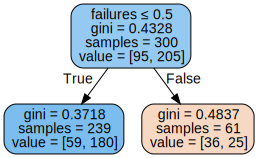

In [51]:
## Code to build decision tree visualization

from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus as pydot

clf = DecisionTreeClassifier(max_depth=1)

train_classifier(clf, X_train, y_train)

fname = 'my_tree.dot'
export_graphviz(clf, out_file=fname,  
                feature_names=X_all.columns,  
                filled=True, rounded=True,  
                special_characters=True)

with open(fname) as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

## How it works

### Training

Decision Trees are a recursive algorithm that build a tree by making binary (yes or no) decisions to make predictions on data. At each iteration, the algorithm looks at the feature which best (most accurate prediction) splits the training data. Successive splits are independent of one another. For example, the decision tree below first looks at the rate of failures of a student, as this was the feature with the best prediction rate. Out of the group with a rate of failures `<= 0.5` the best splitting metric turned out to be `schoolsup` (suplementary school work). Several parameters can be tuned to prevent the tree from overfitting, which would cause bad results on testing data. This tree is then used for prediction.

### Prediction
For students with a failure rate `<= 0.5`, it looks at students with `schoolsup > 0.5` and flags them as at risk for failure. `schoolsup` (supplementary school work) was indicated as the best splitting feature after a failure rate of ` <= 0.5`. For students with a failure rate `> 0.5` it looks at students with absenses `> 17.5`, and flags them as at risk to fail. Students with `<= 17.5` absenses are not flagged.

## Our Final Tree
We found that the optimal tree only had one node: an individaul's failure rates. It flags them if they are greater than `0.5`. This was the best indicator of failure we found by looking at the dataset. While adding more nodes reduced our training error, it did not reduce our testing error: there seems to be more successive correlation between other features and student success. See the visualization below to see the result of the decision tree trained on our training data.

## Example Graph
For illustration only, this was not optimal.

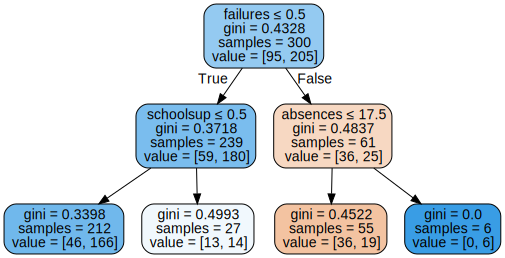

In [41]:
graphviz.Source(dot_graph)